### Setup

In [1]:
import networkx as nx
import json
import os
import yaml
from textwrap import dedent
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exec(open("/tools/C/nayiri/power/power-analysis/variables.py").read())
exec(open(f"{power_analysis_dir}/util.py").read())

In [3]:
my_rtls = [
    'RocketConfig',
    'SmallBoomConfig',
    'MediumBoomConfig',
    'LargeBoomConfig',
    'MegaBoomConfig',
]
my_workloads = ['mm', 'qsort']
rtl_data_dict = {rtl: {} for rtl in my_rtls}
overwrite=False

### Run RTL Sim

In [4]:
for rtl in my_rtls:
    print(f"make CONFIG={rtl} buildfile")

make CONFIG=RocketConfig buildfile
make CONFIG=SmallBoomConfig buildfile
make CONFIG=MediumBoomConfig buildfile
make CONFIG=LargeBoomConfig buildfile
make CONFIG=MegaBoomConfig buildfile


#### Commit log

In [5]:
exec(open(f"{power_analysis_dir}/util.py").read())
for rtl in my_rtls:
    print_sim_out_commands(my_workloads,rtl,overwrite=overwrite)

bsubq make sim-out CONFIG=SmallBoomConfig BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/mm.riscv
bsubq make sim-out CONFIG=SmallBoomConfig BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/qsort.riscv
make redo-sim-rtl CONFIG=MediumBoomConfig HAMMER_EXTRA_ARGS="--stop_before_step run_simulation" 
bsubq make sim-out CONFIG=MediumBoomConfig BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/mm.riscv
bsubq make sim-out CONFIG=MediumBoomConfig BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/qsort.riscv
make redo-sim-rtl CONFIG=LargeBoomConfig HAMMER_EXTRA_ARGS="--stop_before_step run_simulation" 
bsubq make sim-out CONFIG=LargeBoomConfig BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/mm.riscv
bsubq mak

#### FSDB Waveform

In [6]:
exec(open(f"{power_analysis_dir}/util.py").read())
for rtl in my_rtls:
    print_sim_commands(my_workloads,rtl,overwrite=overwrite, parallel=False)

### Parse RTL Sim Waveforms

In [7]:
exec(open(f"{power_analysis_dir}/util.py").read())
for rtl in my_rtls:
    print_fsdb_commands(my_workloads,rtl, overwrite=overwrite)



e fsdb
./scripts/print_headers.py --rtl MediumBoomConfig --workloads "qsort"
./scripts/parse_headers.py --rtl MediumBoomConfig  --workloads "qsort"
bsubq ./scripts/dump_toggles.py --rtl MediumBoomConfig  --workloads "qsort" 


e fsdb
./scripts/print_headers.py --rtl LargeBoomConfig --workloads "qsort"
./scripts/parse_headers.py --rtl LargeBoomConfig  --workloads "qsort"
bsubq ./scripts/dump_toggles.py --rtl LargeBoomConfig  --workloads "qsort" 


e fsdb
./scripts/print_headers.py --rtl MegaBoomConfig --workloads "qsort"
./scripts/parse_headers.py --rtl MegaBoomConfig  --workloads "qsort"
bsubq ./scripts/dump_toggles.py --rtl MegaBoomConfig  --workloads "qsort" 



### Run Hammer + Joules
Generate Hammer YAML Config + Commands to create one report per waveform

In [8]:
exec(open(f"{power_analysis_dir}/util.py").read())

for rtl in my_rtls:
    print_joules_commands(my_workloads,rtl=rtl, overwrite=overwrite)

### Get power traces

In [12]:
exec(open(f"{power_analysis_dir}/util.py").read())

for rtl in my_rtls:
    toggles, jpower, _ = get_workloads_toggles_jpower(my_workloads, rtl)
    rtl_data_dict[rtl]['toggles'] = toggles
    rtl_data_dict[rtl]['jpower'] = jpower

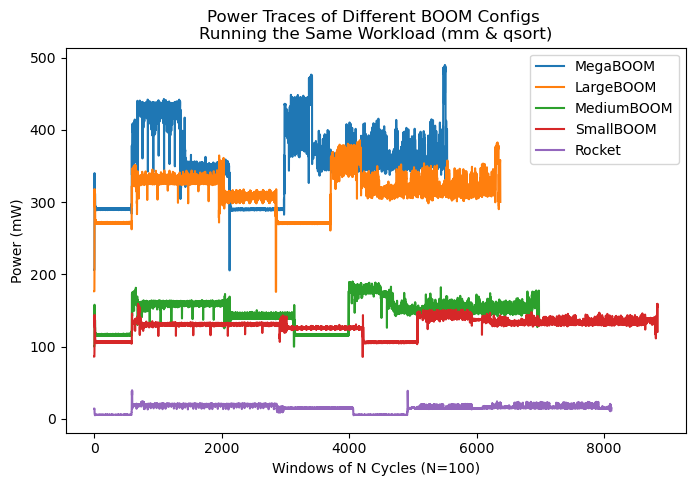

In [14]:
plt.figure(figsize=(8,5))
tmp = my_rtls.copy()
tmp.reverse()
for rtl in tmp:
    if 'jpower' in rtl_data_dict[rtl]: 
        power = rtl_data_dict[rtl]['jpower']
        plt.plot(power, label=get_rtl_name(rtl))
    # if rtl == 'MedRocketConfigP': break
plt.legend()
plt.title('Power Traces of Different BOOM Configs \nRunning the Same Workload (mm & qsort)')
plt.legend(loc='upper right')
plot_power_adjustments()


In [11]:
plt.figure(figsize=(8,5))
tmp = my_rtls.copy()
tmp.reverse()
for rtl in tmp:
    if 'jpower' in rtl_data_dict[rtl]: 
        power = rtl_data_dict[rtl]['jpower']
        scaler_y = sklearn.preprocessing.StandardScaler()
        power = scaler_y.fit_transform(numpy.array(power).reshape(-1,1)).reshape(-1)
        plt.plot(power, label=get_rtl_name(rtl))
    # if rtl == 'MedRocketConfigP': break
plt.legend()
plt.title('Scaled Power Traces of Different BOOM Configs \nRunning the Same Workload (mm)')
plt.legend(loc='upper right')
plot_power_adjustments()
plt.ylabel('Power (Scaled)')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

<Figure size 800x500 with 0 Axes>

### Matching signals

How many signals in different RTL configs remain the same?

In [ ]:
train_rtl = my_rtls[1]
test_rtl = my_rtls[2]

In [ ]:
lens =[]
for rtl in my_rtls:
    idcodes_proxies = get_idcodes_proxies(rtl)
    proxies = [p for i,p in idcodes_proxies]
    rtl_data_dict[rtl]['idcodes_proxies'] = idcodes_proxies
    rtl_data_dict[rtl]['proxies'] = proxies
    rtl_data_dict[rtl]['proxies_idxs_dict'] = {p:i for i,p in enumerate(proxies)}
    lens.append(len(proxies))

common_proxies = set(rtl_data_dict[train_rtl]['proxies'])
my_rtls_test = [my_rtls[i] for i in range(my_rtls.index(train_rtl),len(my_rtls))]
for rtl in my_rtls_test:
    common_proxies = common_proxies.intersection(rtl_data_dict[rtl]['proxies'])

for rtl in my_rtls_test:
    rtl_data_dict[rtl]['common_idxs'] = [rtl_data_dict[rtl]['proxies_idxs_dict'][p] for p in common_proxies]

len(common_proxies), lens

(44301, [28155, 57883, 74350, 109880, 154246])

In [ ]:
exec(open(f"{power_analysis_dir}/util.py").read())


X_train = rtl_data_dict[train_rtl]['toggles'][:,rtl_data_dict[train_rtl]['common_idxs']]
X_test  = rtl_data_dict[test_rtl]['toggles'][:,rtl_data_dict[test_rtl]['common_idxs']]
y_train = rtl_data_dict[train_rtl]['jpower']
y_test = rtl_data_dict[test_rtl]['jpower']
X_train.shape, X_test.shape

((4211, 44301), (3133, 44301))

In [ ]:
exec(open(f"{power_analysis_dir}/util.py").read())

ret_dict = apollo(X_train, X_test, y_train, y_test, verbose=True)

Creating linear_model of type mcp...
Fitting model to data...
R^2 = 0.99, NRMSE = 1%
Num coefs:  101
Creating linear_model of type ridge...
Fitting model to data...
R^2 = 0.99, NRMSE = 1%
Num coefs:  101
Predicting y based on X...
R^2 = -0.24, NRMSE = 13%


In [ ]:
dump_proxy_signals(ret_dict['coef_indexes'],rtl=train_rtl)

Wrote signals to: /tools/C/nayiri/power/power-analysis/out/proxy_signals/SmallBoomConfig.txt


''

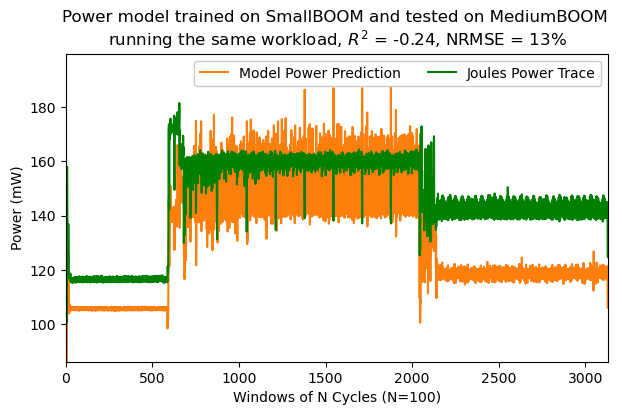

In [ ]:
exec(open(f"{power_analysis_dir}/util.py").read())

plot_power(y_test,ret_dict['y_pred'], fig=plt.figure(figsize=(7,4)), 
            title=f'Power model trained on {get_rtl_name(train_rtl)} and tested on {get_rtl_name(test_rtl)} \nrunning the same workload')
plt.ylim(min(np.concatenate((y_test,ret_dict['y_pred']))), max(y_test)*1.1)

;

In [ ]:
my_rtls_test = [my_rtls[i] for i in range(my_rtls.index(train_rtl)+1,len(my_rtls))]
for test_rtl in my_rtls_test:
    print(test_rtl.ljust(25),end='')
    X_train = rtl_data_dict[train_rtl]['toggles'][:,rtl_data_dict[train_rtl]['common_idxs']]
    X_test  = rtl_data_dict[test_rtl]['toggles'][:,rtl_data_dict[test_rtl]['common_idxs']]
    y_train = rtl_data_dict[train_rtl]['jpower']
    y_test = rtl_data_dict[test_rtl]['jpower']
    ret_dict = apollo(X_train, X_test, y_train, y_test, print_errors='oneline')
    rtl_data_dict[test_rtl]['ret_dict'] = ret_dict
    print()

MediumBoomConfig         

	 -0.24 	 13
LargeBoomConfig          	 -57.58 	 58
MegaBoomConfig           	 -18.25 	 68


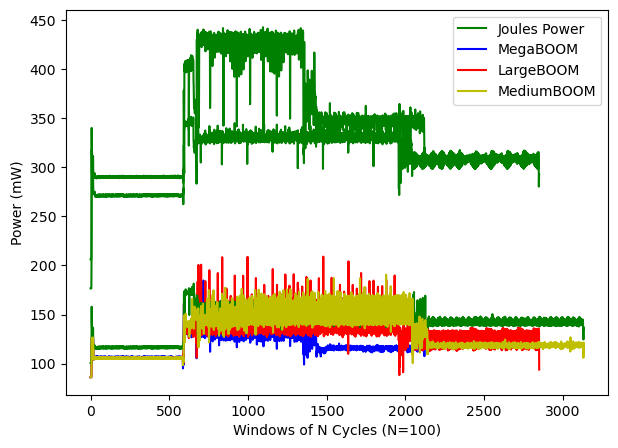

In [ ]:
plt.figure(figsize=(7,5))
tmp = my_rtls_test.copy()
tmp.reverse()
colors = 'bry'
for test_rtl,c in zip(tmp,colors):
    if test_rtl == tmp[0]:
        plt.plot(rtl_data_dict[test_rtl]['jpower'],'g',label='Joules Power')
    else:
        plt.plot(rtl_data_dict[test_rtl]['jpower'],'g')
    plt.plot(rtl_data_dict[test_rtl]['ret_dict']['y_pred'],c,label=get_rtl_name(test_rtl))
plt.legend(loc='upper right')
plot_power_adjustments()

''

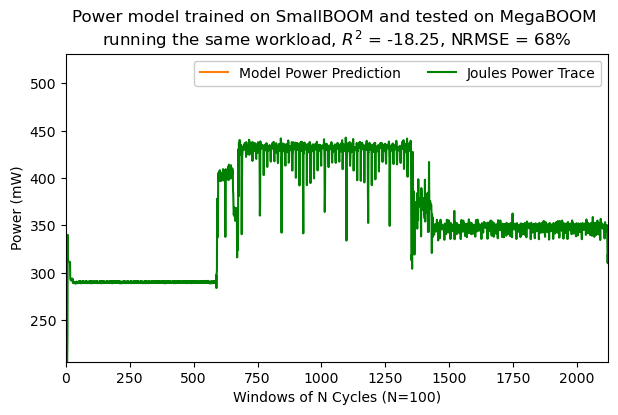

In [ ]:
exec(open(f"{power_analysis_dir}/util.py").read())

test_rtl = my_rtls_test[-1]
plot_power(y_test,rtl_data_dict[test_rtl]['ret_dict']['y_pred'], fig=plt.figure(figsize=(7,4)), 
            title=f'Power model trained on {get_rtl_name(train_rtl)} and tested on {get_rtl_name(test_rtl)} \nrunning the same workload')
plt.ylim(min(y_test), max(y_test)*1.2)

;